# A frameshift mutation in the methyltransferase _rlmN_ is associated with linezolid resistance in _Mycobacterium tuberculosis_

This ipynb file records the data analysis for associating a frameshift mutation in the methyltransferase _rlmN_ with linezolid resistance in MTB.

At the end of each section, intermediate data is saved to a file that is then read in at the start of the next section, so each section's analyses can be completed independently if desired.

In [1]:
import pandas as pd
import numpy as np

# plotting for the QC visualizations
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Reading in the phenotype and genotype annotation data from the BV-BRC

The BV-BRC phenotype data are all stored in the related CSV file.

In [2]:
df = pd.read_csv("./BVBRC_linezolid_phenotype_31Jul25_lab_method_biosamples.csv")

# drop anything where all columns are the same
df.drop_duplicates(inplace=True)

In [3]:
df.head()

,BioSample Accession,BAKTA,size,contigs_orig,MIC
0,SAMEA7525314,atb.bakta.r0.2.batch.342.tar.xz,4331464,153,0.50
1,SAMEA7563280,atb.bakta.r0.2.batch.346.tar.xz,4298530,136,0.25
2,SAMEA7562884,atb.bakta.r0.2.batch.346.tar.xz,4338561,110,0.25
3,SAMEA7526196,atb.bakta.r0.2.batch.342.tar.xz,4381306,107,0.25
4,SAMEA8741163,atb.bakta.r0.2.batch.347.tar.xz,4311592,151,0.50


In [4]:
# 8364 assemblies were downloaded from AllTheBacteria, per downloaded_assemblies.txt
# However, 8454 assemblies have phenotypic data
df.shape

(8454, 5)

In [5]:
# There are more phenotypes than genotypes, so subset to successfully downloaded assemblies
downloaded_genomes = pd.read_csv("../blast_search/downloaded_assemblies.txt",header=None,
                                names=["BioSample Accession"])
downloaded_genomes_list = list(downloaded_genomes["BioSample Accession"])
print(len(downloaded_genomes_list))

8364


In [6]:
# Store which isolates have successful assemblies downloaded
df["in_downloads"] = df["BioSample Accession"].apply(lambda x: x in downloaded_genomes_list)

In [7]:
df = df[df["in_downloads"]]
df.shape

(8364, 6)

In [8]:
# Number of isolates missing MIC values
print(f"Number of isolates missing MIC values: {df['MIC'].isna().sum()}")
print("Dropping isolates with missing MIC values...")
df = df[-df['MIC'].isna()]
print(df.shape)

Number of isolates missing MIC values: 15
Dropping isolates with missing MIC values...
(8349, 6)


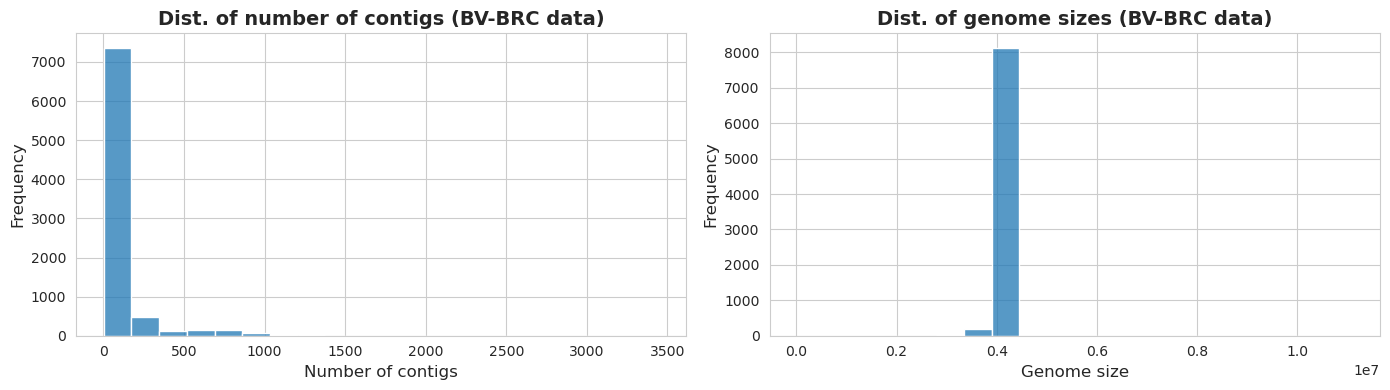

In [9]:
sns.set_style("whitegrid")

f = plt.figure(figsize=(14,4))
gs = f.add_gridspec(1,2)

ax = f.add_subplot(gs[0,0])
sns.histplot(
    df['contigs_orig'],
    bins=20
)

plt.title("Dist. of number of contigs (BV-BRC data)", fontsize=14, weight='bold')
plt.xlabel("Number of contigs", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

ax = f.add_subplot(gs[0,1])
sns.histplot(
    df['size'],
    bins=20
)

plt.title("Dist. of genome sizes (BV-BRC data)", fontsize=14, weight='bold')
plt.xlabel("Genome size", fontsize=12)
plt.ylabel("Frequency", fontsize=12)


f.tight_layout()

In [10]:
df[['size', 'contigs_orig']].describe()

,size,contigs_orig
count,8.349000e+03,8349.000000
mean,4.311358e+06,146.564379
std,2.336769e+05,160.542479
min,1.897500e+04,1.000000
25%,4.306607e+06,93.000000
50%,4.336344e+06,108.000000
75%,4.351386e+06,135.000000
max,1.110023e+07,3444.000000


In [11]:
df["calc_R_S"] = df["MIC"].apply(lambda x: "R" if x > 1.0 else "S") # WHO breakpoint = 1.0 mg/L

In [12]:
df.groupby(by="calc_R_S").describe()

size                                                      \
           count          mean            std        min         25%   
calc_R_S                                                               
R          143.0  4.426160e+06  527557.441502  4226051.0  4335504.50   
S         8206.0  4.309358e+06  224735.749778    18975.0  4306045.75   

                                            contigs_orig              ...  \
                50%         75%         max        count        mean  ...   
calc_R_S                                                              ...   
R         4358692.0  4390599.00   9920477.0        143.0   80.356643  ...   
S         4336064.0  4350972.25  11100226.0       8206.0  147.718133  ...   

                            MIC                                            \
            75%     max   count      mean       std   min   25%  50%  75%   
calc_R_S                                                                    
R         111.5   302.0   143.0  4.055944  2.703092  2.00  2.00  3.0  4.0   
S         135.0  3444.0  8206.0  0.411437  0.233585  0.03  0.25  0.5  0.5   

                
           max  
calc_R_S        
R         10.0  
S          1.0  

[2 rows x 24 columns]

In [13]:
print(f"Before filtering, {100*(143/(143+8206))}% resistance")

Before filtering, 1.7127799736495388% resistance


Text(0, 0.5, 'Genome size')

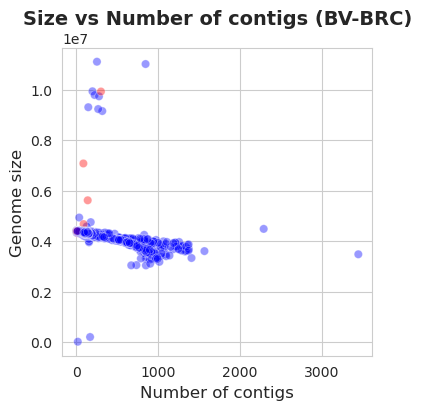

In [14]:
# As number of contigs goes up, so does the genome size, likely due to poor-quality reads 
# making the assembly difficult and resulting in a fragmented, small genome
# Red dots show resistant isolates
f = plt.figure(figsize=(4,4))

sns.scatterplot(
    x=df['contigs_orig'],
    y=df['size'],
    alpha=0.4,
    color=df['calc_R_S'].apply(lambda x: "red" if x=="R" else "blue")
)

plt.title("Size vs Number of contigs (BV-BRC)", fontsize=14, weight='bold')
plt.xlabel("Number of contigs", fontsize=12)
plt.ylabel("Genome size", fontsize=12)


In [15]:
# only allow genomes within a reasonable length of H37Rv
h37rv_length = 4411532
lower_bound = h37rv_length*0.95
upper_bound = h37rv_length*1.05

In [16]:
# How many sensitive and resistant will we be filtering?
df.query(f'size < {lower_bound} or size > {upper_bound}').groupby(by="calc_R_S").describe()

size                                                                \
          count          mean           std        min         25%        50%   
calc_R_S                                                                        
R           4.0  6.821157e+06  2.290040e+06  4673834.0  5380568.75  6345158.5   
S         570.0  3.997731e+06  7.789881e+05    18975.0  3806325.00  3978715.5   

                                 contigs_orig              ...                 \
                 75%         max        count        mean  ...    75%     max   
calc_R_S                                                   ...                  
R         7785746.75   9920477.0          4.0  152.750000  ...  178.5   300.0   
S         4103654.00  11100226.0        570.0  644.092982  ...  797.0  3444.0   

            MIC                                                 
          count      mean       std   min   25%  50%  75%  max  
calc_R_S                                                        
R           4.0  2.500000  1.000000  2.00  2.00  2.0  2.5  4.0  
S         570.0  0.435237  0.204217  0.03  0.25  0.5  0.5  1.0  

[2 rows x 24 columns]

In [17]:
df.query(f'size >= {lower_bound} and size <= {upper_bound} and contigs_orig > 1000').groupby(by="calc_R_S").describe()

size                                                             \
         count       mean std        min        25%        50%        75%   
calc_R_S                                                                    
S          1.0  4484600.0 NaN  4484600.0  4484600.0  4484600.0  4484600.0   

                    contigs_orig          ...                   MIC            \
                max        count    mean  ...     75%     max count  mean std   
calc_R_S                                  ...                                   
S         4484600.0          1.0  2288.0  ...  2288.0  2288.0   1.0  0.25 NaN   

                                        
           min   25%   50%   75%   max  
calc_R_S                                
S         0.25  0.25  0.25  0.25  0.25  

[1 rows x 24 columns]

In [18]:
df = df.query(f'size >= {lower_bound} and size <= {upper_bound}')
print(df.groupby(by="calc_R_S").describe())
print(f"After size filtering, {100*(139/(139+7636))}% resistance")

            size                                                               \
           count          mean           std        min        25%        50%   
calc_R_S                                                                        
R          139.0  4.357239e+06  36499.295880  4226051.0  4334952.0  4354011.0   
S         7636.0  4.332619e+06  35525.346307  4191081.0  4314304.0  4338496.0   

                                contigs_orig              ...                 \
                 75%        max        count        mean  ...    75%     max   
calc_R_S                                                  ...                  
R         4385892.00  4431065.0        139.0   78.273381  ...  110.5   302.0   
S         4352579.75  4581734.0       7636.0  110.665532  ...  128.0  2288.0   

             MIC                                                  
           count      mean       std   min   25%  50%  75%   max  
calc_R_S                                                   

Text(0, 0.5, 'Genome size')

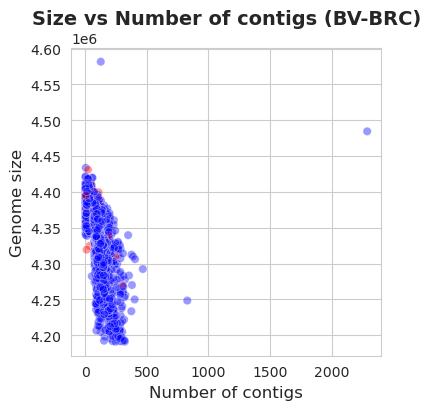

In [19]:
# red dots show resistant isolates
f = plt.figure(figsize=(4,4))

sns.scatterplot(
    x=df['contigs_orig'],
    y=df['size'],
    alpha=0.4,
    color=df['calc_R_S'].apply(lambda x: "red" if x=="R" else "blue")
)

plt.title("Size vs Number of contigs (BV-BRC)", fontsize=14, weight='bold')
plt.xlabel("Number of contigs", fontsize=12)
plt.ylabel("Genome size", fontsize=12)


In [20]:
# We will also remove the below accession for which BLAST could not find any ribosomal DNA
df = df[df["BioSample Accession"] != "SAMEA7564145"]

In [21]:
df.groupby(by="calc_R_S").describe()

size                                                               \
           count          mean           std        min        25%        50%   
calc_R_S                                                                        
R          139.0  4.357239e+06  36499.295880  4226051.0  4334952.0  4354011.0   
S         7635.0  4.332624e+06  35525.832376  4191081.0  4314323.0  4338498.0   

                               contigs_orig              ...                 \
                75%        max        count        mean  ...    75%     max   
calc_R_S                                                 ...                  
R         4385892.0  4431065.0        139.0   78.273381  ...  110.5   302.0   
S         4352582.5  4581734.0       7635.0  110.658022  ...  128.0  2288.0   

             MIC                                                  
           count      mean       std   min   25%  50%  75%   max  
calc_R_S                                                          
R          139.0  4.100719  2.724805  2.00  2.00  4.0  4.0  10.0  
S         7635.0  0.409648  0.235559  0.03  0.25  0.5  0.5   1.0  

[2 rows x 24 columns]

In [22]:
print(f"After filtering an isolate missing ribosomal DNA, {100*(139/(139+7635))}% resistance")

After filtering an isolate missing ribosomal DNA, 1.788011319783895% resistance


In [23]:
# Uncomment to save intermediate files
# df.to_csv("1_filtered_geno_data.csv", index=False)

## 2. Reading in the data from the BLAST searches

In [25]:
df = pd.read_csv("1_filtered_geno_data.csv")

blast_col_names = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen',
                   'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'sseq']

def get_blast_info(acc, file_stub):
    tmp = pd.read_csv(f"../blast_search/blast_results/{acc}/{file_stub}_test.blast",
                      sep='\t', header=None, names=blast_col_names)

    if(tmp.shape[0] < 1):
        print(f"Missing {file_stub} for {acc}")
        return pd.Series({
            f"{file_stub}_pident": None,
            f"{file_stub}_length": None, 
            f"{file_stub}_sseq": None
        })

    return pd.Series({
        f"{file_stub}_pident": tmp["pident"].iloc[0],
        f"{file_stub}_length": tmp["length"].iloc[0], 
        f"{file_stub}_sseq": tmp["sseq"].iloc[0]
    })

In [26]:
# look through the BLAST files to find the gene matches

# This step takes a long time (several minutes)
# So I comment it out and read in a copy instead for the purposes of this file
# You can replicate my original analysis by uncommenting and running the for loop

# If you want to replicate this fully, you will also need to perform the BLAST 
# searches to generate the BLAST files. Instructions for this are on the github as well.

#for file_stub in ["rrl", "rplC", "tsnR", "rlmN"]:
#    df[[f"{file_stub}_pident",f"{file_stub}_length",f"{file_stub}_sseq"]] = \
#       df["BioSample Accession"].apply(lambda x: get_blast_info(x, file_stub))
#df.to_csv("2a_biosamples_with_BLAST_data.csv", index=False)
df = pd.read_csv("2a_biosamples_with_BLAST_data.csv")

In [27]:
df.head()

,BioSample Accession,BAKTA,size,contigs_orig,MIC,in_downloads,calc_R_S,rrl_pident,rrl_length,rrl_sseq,rplC_pident,rplC_length,rplC_sseq,tsnR_pident,tsnR_length,tsnR_sseq,rlmN_pident,rlmN_length,rlmN_sseq
0,SAMEA7525314,atb.bakta.r0.2.batch.342.tar.xz,4331464,153,0.50,True,S,99.968,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.615,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,99.471,189,WGEPLANYARVLAAVQRITARPPSGFGISARAVTVSTVGLAPAIRN...
1,SAMEA7563280,atb.bakta.r0.2.batch.346.tar.xz,4298530,136,0.25,True,S,99.904,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...
2,SAMEA7562884,atb.bakta.r0.2.batch.346.tar.xz,4338561,110,0.25,True,S,99.968,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...
3,SAMEA7526196,atb.bakta.r0.2.batch.342.tar.xz,4381306,107,0.25,True,S,99.968,3139,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...
4,SAMEA8741163,atb.bakta.r0.2.batch.347.tar.xz,4311592,151,0.50,True,S,100.000,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...


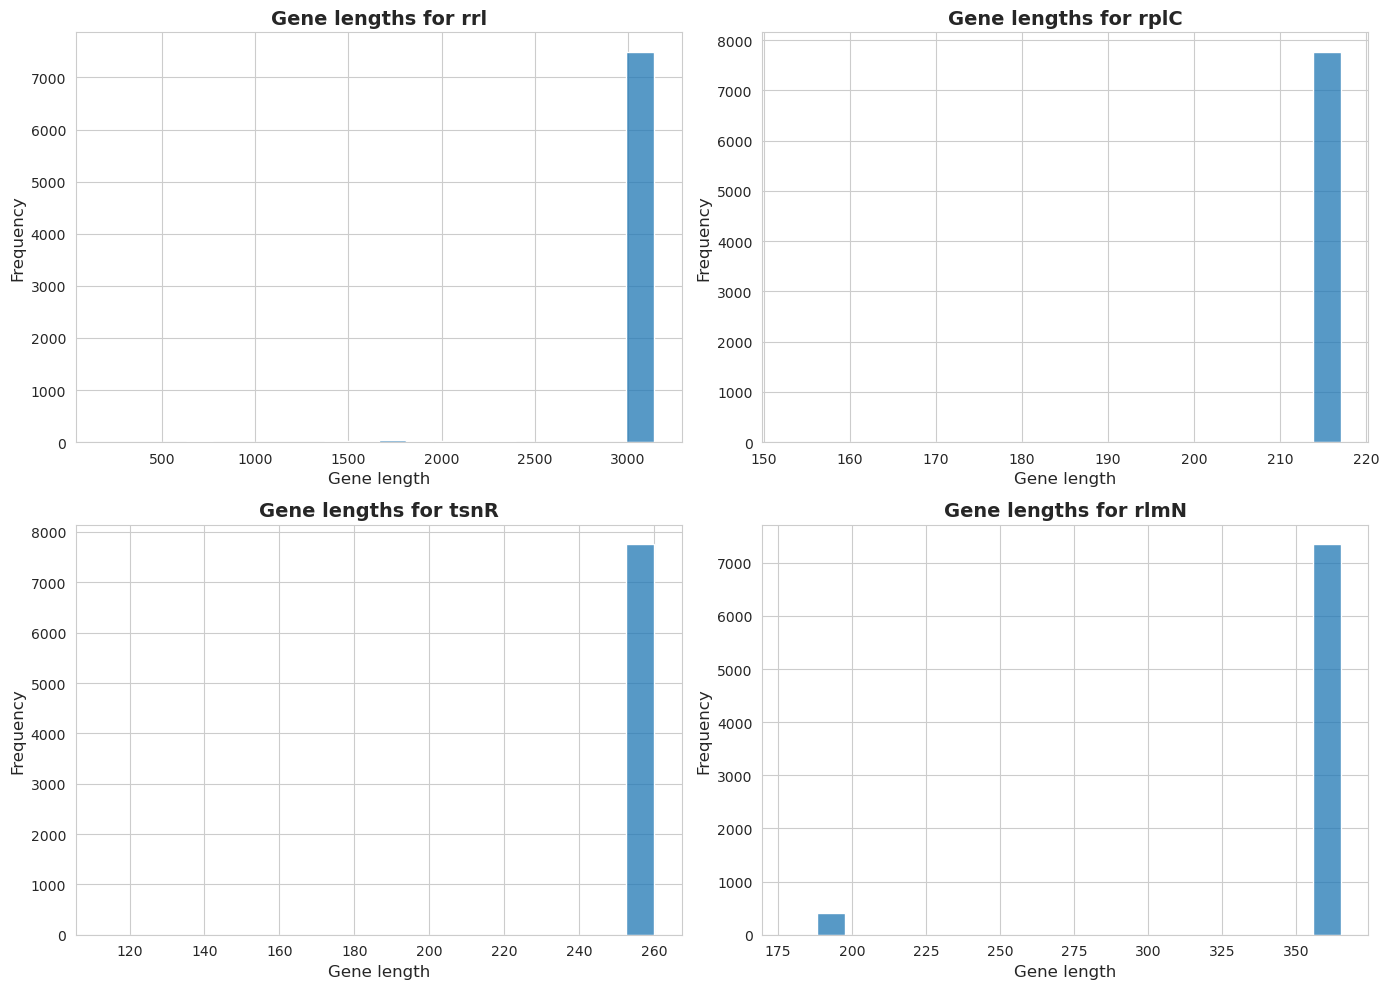

In [34]:
sns.set_style("whitegrid")

f = plt.figure(figsize=(14,10))
gs = f.add_gridspec(2,2)

ax = f.add_subplot(gs[0,0])
sns.histplot(
    df['rrl_length'],
    bins=20
)

plt.title("Gene lengths for rrl", fontsize=14, weight='bold')
plt.xlabel("Gene length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

##

ax = f.add_subplot(gs[0,1])
sns.histplot(
    df['rplC_length'],
    bins=20
)

plt.title("Gene lengths for rplC", fontsize=14, weight='bold')
plt.xlabel("Gene length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

##

ax = f.add_subplot(gs[1,0])
sns.histplot(
    df['tsnR_length'],
    bins=20
)

plt.title("Gene lengths for tsnR", fontsize=14, weight='bold')
plt.xlabel("Gene length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

##

ax = f.add_subplot(gs[1,1])
sns.histplot(
    df['rlmN_length'],
    bins=20
)

plt.title("Gene lengths for rlmN", fontsize=14, weight='bold')
plt.xlabel("Gene length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)


f.tight_layout()

In [36]:
df['rlmN_length'].value_counts().head() # all other value counts have 0-1 isolates

rlmN_length
364    7342
189     413
204       1
346       1
342       1
Name: count, dtype: int64

In [39]:
print(f"{100*(413/(413+7342)):.2f}% of isolates have a short rlmN")

5.33% of isolates have a short rlmN


In [41]:
# Filter out indels with very small numbers of isolates (<= 1% of isolates)
df = df.query("(rlmN_length == 364 or rlmN_length == 189) and rrl_length == 3138 and tsnR_length == 260 and rplC_length == 217")

In [42]:
df.head()

,BioSample Accession,BAKTA,size,contigs_orig,MIC,in_downloads,calc_R_S,rrl_pident,rrl_length,rrl_sseq,rplC_pident,rplC_length,rplC_sseq,tsnR_pident,tsnR_length,tsnR_sseq,rlmN_pident,rlmN_length,rlmN_sseq
0,SAMEA7525314,atb.bakta.r0.2.batch.342.tar.xz,4331464,153,0.50,True,S,99.968,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.615,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,99.471,189,WGEPLANYARVLAAVQRITARPPSGFGISARAVTVSTVGLAPAIRN...
1,SAMEA7563280,atb.bakta.r0.2.batch.346.tar.xz,4298530,136,0.25,True,S,99.904,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...
2,SAMEA7562884,atb.bakta.r0.2.batch.346.tar.xz,4338561,110,0.25,True,S,99.968,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...
4,SAMEA8741163,atb.bakta.r0.2.batch.347.tar.xz,4311592,151,0.50,True,S,100.000,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...
5,SAMEA7561621,atb.bakta.r0.2.batch.346.tar.xz,4306612,172,0.50,True,S,100.000,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...


In [45]:
#df.to_csv('2b_biosamples_with_genes.csv', index=False)

## 3. Extracting mutations from the genes

In [272]:
df = pd.read_csv('2b_biosamples_with_genes.csv')

In [273]:
df.head()

,BioSample Accession,BAKTA,size,contigs_orig,MIC,in_downloads,calc_R_S,rrl_pident,rrl_length,rrl_sseq,rplC_pident,rplC_length,rplC_sseq,tsnR_pident,tsnR_length,tsnR_sseq,rlmN_pident,rlmN_length,rlmN_sseq
0,SAMEA7525314,atb.bakta.r0.2.batch.342.tar.xz,4331464,153,0.50,True,S,99.968,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.615,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,99.471,189,WGEPLANYARVLAAVQRITARPPSGFGISARAVTVSTVGLAPAIRN...
1,SAMEA7563280,atb.bakta.r0.2.batch.346.tar.xz,4298530,136,0.25,True,S,99.904,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...
2,SAMEA7562884,atb.bakta.r0.2.batch.346.tar.xz,4338561,110,0.25,True,S,99.968,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...
3,SAMEA8741163,atb.bakta.r0.2.batch.347.tar.xz,4311592,151,0.50,True,S,100.000,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...
4,SAMEA7561621,atb.bakta.r0.2.batch.346.tar.xz,4306612,172,0.50,True,S,100.000,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,100.0,217,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...


In [48]:
rlmN_full = "MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAHQYYGRLIADPRQMTDLPAAVRDRIAGAMFPNLLTASADITCDAGQTRKTLWRAVDGTMFESVLMRYPRRNTVCISSQAGCGMACPFCATGQGGLTRNLSTAEILEQVRAGAAALRDDFGDRLSNVVFMGMGEPLANYARVLAAVQRITARPPSGFGISARAVTVSTVGLAPAIRNLADARLGVTLALSLHAPDDGLRDTLVPVNNRWRISEALDAARYYANVTGRRVSIEYALIRDVNDQPWRADLLGKRLHRVLGPLAHVNLIPLNPTPGSDWDASPKPVEREFVKRVRAKGVSCTVRDTRGREISAACGQLAAVGG"
rlmN_frameshift = "MGEPLANYARVLAAVQRITARPPSGFGISARAVTVSTVGLAPAIRNLADARLGVTLALSLHAPDDGLRDTLVPVNNRWRISEALDAARYYANVTGRRVSIEYALIRDVNDQPWRADLLGKRLHRVLGPLAHVNLIPLNPTPGSDWDASPKPVEREFVKRVRAKGVSCTVRDTRGREISAACGQLAAVGG"

# rplC was not used in the final paper
rplC_full = "MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDGYSAVQLAYGEISPRKVNKPLTGQYTAAGVNPRRYLAELRLDDSDAATEYQVGQELTAEIFADGSYVDVTGTSKGKGFAGTMKRHGFRGQGASHGAQAVHRRPGSIGGCATPARVFKGTRMAGRMGNDRVTVLNLLVHKVDAENGVLLIKGAVPGRTGGLVMVRSAIKRGEK"
rplD_full = "MAAQEQKTLKIDVKTPAGKVDGAIELPAELFDVPANIALMHQVVTAQRAAARQGTHSTKTRGEVSGGGRKPYRQKGTGRARQGSTRAPQFTGGGVVHGPKPRDYSQRTPKKMIAAALRGALSDRARNGRIHAITELVEGQNPSTKSARAFLASLTERKQVLVVIGRSDEAGAKSVRNLPGVHILAPDQLNTYDVLRADDVVFSVEALNAYIAANTTTSEEVSA"

tsnR_full = "MLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVREVFVTEVAARRHELLLAAHEASVHLVTERAAKALSDTVTPAGLVAVCDLPATRLEDVLAGSPQLIAVTVEIREPGNAGTVIRIADAMGAAAVILAGRSVDPYNGKCLRASTGSIFAIPVVVAPDVGAAIADLRAAGLQVLATAVDGEMALDDADRLLAEPTAWLFGPEAHGLSAEIAALADHRVHILMSGGAESLNVAAAAAICLYESARALGRR"

# rrs was not used in the final paper
rrs_full = "TTTTGTTTGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACACATGCAAGTCGAACGGAAAGGTCTCTTCGGAGATACTCGAGTGGCGAACGGGTGAGTAACACGTGGGTGATCTGCCCTGCACTTCGGGATAAGCCTGGGAAACTGGGTCTAATACCGGATAGGACCACGGGATGCATGTCTTGTGGTGGAAAGCGCTTTAGCGGTGTGGGATGAGCCCGCGGCCTATCAGCTTGTTGGTGGGGTGACGGCCTACCAAGGCGACGACGGGTAGCCGGCCTGAGAGGGTGTCCGGCCACACTGGGACTGAGATACGGCCCAGACTCCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCGACGCCGCGTGGGGGATGACGGCCTTCGGGTTGTAAACCTCTTTCACCATCGACGAAGGTCCGGGTTCTCTCGGATTGACGGTAGGTGGAGAAGAAGCACCGGCCAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTGTCCGGAATTACTGGGCGTAAAGAGCTCGTAGGTGGTTTGTCGCGTTGTTCGTGAAATCTCACGGCTTAACTGTGAGCGTGCGGGCGATACGGGCAGACTAGAGTACTGCAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCAGTAACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGGTGGGTACTAGGTGTGGGTTTCCTTCCTTGGGATCCGTGCCGTAGCTAACGCATTAAGTACCCCGCCTGGGGAGTACGGCCGCAAGGCTAAAACTCAAAGGAATTGACGGGGGCCCGCACAAGCGGCGGAGCATGTGGATTAATTCGATGCAACGCGAAGAACCTTACCTGGGTTTGACATGCACAGGACGCGTCTAGAGATAGGCGTTCCCTTGTGGCCTGTGTGCAGGTGGTGCATGGCTGTCGTCAGCTCGTGTCGTGAGATGTTGGGTTAAGTCCCGCAACGAGCGCAACCCTTGTCTCATGTTGCCAGCACGTAATGGTGGGGACTCGTGAGAGACTGCCGGGGTCAACTCGGAGGAAGGTGGGGATGACGTCAAGTCATCATGCCCCTTATGTCCAGGGCTTCACACATGCTACAATGGCCGGTACAAAGGGCTGCGATGCCGCGAGGTTAAGCGAATCCTTAAAAGCCGGTCTCAGTTCGGATCGGGGTCTGCAACTCGACCCCGTGAAGTCGGAGTCGCTAGTAATCGCAGATCAGCAACGCTGCGGTGAATACGTTCCCGGGCCTTGTACACACCGCCCGTCACGTCATGAAAGTCGGTAACACCCGAAGCCAGTGGCCTAACCCTCGGGAGGGAGCTGTCGAAGGTGGGATCGGCGATTGGGACGAAGTCGTAACAAGGTAGCCGTACCGGAAGGTGCGGCTGGATCACCTCCTTTCT"
rrl_full = "TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGCCGATGAAGGACGTGGGAGGCTGCGATATGCCTCGGGGAGCTGTCAACCGAGCGTGGATCCGAGGATTTCCGAATGGGGAAACCCAGCACGAGTGATGTCGTGCTACCCGCATCTGAATATATAGGGTGCGGGAGGGAACGCGGGGAAGTGAAACATCTCAGTACCCGTAGGAGGAGAAAACAATTGTGATTCCGCAAGTAGTGGCGAGCGAACGCGGAACAGGCTAAACCGCACGCATGGGTAACCGGGTAGGGGTTGTGTGTGCGGGGTTGTGGGAGGATATGTCTCAGCGCTACCCGGCTGAGAGGCAGTCAGAAAGTGTCGTGGTTAGCGGAAGTGGCCTGGGATGGTCTGCCGTAGACGGTGAGAGCCCGGTACGCGAAAACCCGGCACCTGCCTAGTATCAATTCCCGAGTAGCAGCGGGCCCGTGGAATCCGCTGTGAATCCGCCGGGACCACCCGGTAAGCCTAAATACTCCTCGATGACCGATAGCGGATTAGTACCGTGAGGGAATGGTGAAAAGTACCCCGGGAGGGGAGTGAAAGAGTACCTGAAACCGTGTGCCTACAATCCGTCAGAGCCTCCTTTTCCTCTCCGGAGGAGGGTGGTGATGGCGTGCCTTTTGAAGAATGAGCCTGCGAGTCAGGGACATGTCGCAAGGTTAACCCGTGTGGGGTAGCCGCAGCGAAAGCGAGTCTGAATAGGGCGACCCACACGCGCATACGCGCGTGTGAATAGTGGCGTGTTCTGGACCCGAAGCGGAGTGATCTACCCATGGCCAGGGTGAAGCGCGGGTAAGACCGCGTGGAGGCCCGAACCCACTTAGGTTGAAGACTGAGGGGATGAGCTGTGGGTAGGGGTGAAAGGCCAATCAAACTCCGTGATAGCTGGTTCTCCCCGAAATGCATTTAGGTGCAGCGTTGCGTGGTTCACCGCGGAGGTAGAGCTACTGGATGGCCGATGGGCCCTACTAGGTTACTGACGTCAGCCAAACTCCGAATGCCGTGGTGTAAAGCGTGGCAGTGAGACGGCGGGGGATAAGCTCCGTACGTCGAAAGGGAAACAGCCCAGATCGCCGGCTAAGGCCCCCAAGCGTGTGCTAAGTGGGAAAGGATGTGCAGTCGCAAAGACAACCAGGAGGTTGGCTTAGAAGCAGCCACCCTTGAAAGAGTGCGTAATAGCTCACTGGTCAAGTGATTGTGCGCCGATAATGTAGCGGGGCTCAAGCACACCGCCGAAGCCGCGGCACATCCACCTTGTGGTGGGTGTGGGTAGGGGAGCGTCCCTCATTCAGCGAAGCCACCGGGTGACCGGTGGTGGAGGGTGGGGGAGTGAGAATGCAGGCATGAGTAGCGACAAGGCAAGTGAGAACCTTGCCCGCCGAAAGACCAAGGGTTCCTGGGCCAGGCCAGTCCGCCCAGGGTGAGTCGGGACCTAAGGCGAGGCCGACAGGCGTAGTCGATGGACAACGGGTTGATATTCCCGTACCCGTGTGTGGGCGCCCGTGACGAATCAGCGGTACTAACCACCCAAAACCGGATCGATCACTCCCCTTCGGGGGTGTGGAGTTCTGGGGCTGCGTGGGAACTTCGCTGGTAGTAGTCAAGCGAAGGGGTGACGCAGGAAGGTAGCCGTACCAGTCAGTGGTAACACTGGGGCAAGCCGGTAGGGAGAGCGATAGGCAAATCCGTCGCTCACTAATCCTGAGAGGTGACGCATAGCCGGTTGAGGCGAATTCGGTGATCCTCTGCTGCCAAGAAAAGCCTCTAGCGAGCACACACACGGCCCGTACCCCAAACCGACACAGGTGGTCAGGTAGAGCATACCAAGGCGTACGAGATAACTATGGTTAAGGAACTCGGCAAAATGCCCCCGTAACTTCGGGAGAAGGGGGACCGGAATATCGTGAACACCCTTGCGGTGGGAGCGGGATCCGGTCGCAGAAACCAGTGAGGAGCGACTGTTTACTAAAAACACAGGTCCGTGCGAAGTCGCAAGACGATGTATACGGACTGACGCCTGCCCGGTGCTGGAAGGTTAAGAGGACCCGTTAACCCGCAAGGGTGAAGCGGAGAATTTAAGCCCCAGTAAACGGCGGTGGTAACTATAACCATCCTAAGGTAGCGAAATTCCTTGTCGGGTAAGTTCCGACCTGCACGAATGGCGTAACGACTTCTCAACTGTCTCAACCATAGACTCGGCGAAATTGCACTACGAGTAAAGATGCTCGTTACGCGCGGCAGGACGAAAAGACCCCGGGACCTTCACTACAACTTGGTATTGATGTTCGGTACGGTTTGTGTAGGATAGGTGGGAGACTGTGAAACCTCGACGCCAGTTGGGGCGGAGTCGTTGTTGAAATACCACTCTGATCGTATTGGGCATCTAACCTCGAACCCTGAATCGGGTTTAGGGACAGTGCCTGGCGGGTAGTTTAACTGGGGCGGTTGCCTCCTAAAATGTAACGGAGGCGCCCAAAGGTTCCCTCAACCTGGACGGCAATCAGGTGGCGAGTGTAAATGCACAAGGGAGCTTGACTGCGAGACTTACAAGTCAAGCAGGGACGAAAGTCGGGATTAGTGATCCGGCACCCCCGAGTGGAAGGGGTGTCGCTCAACGGATAAAAGGTACCCCGGGGATAACAGGCTGATCTTCCCCAAGAGTCCATATCGACGGGATGGTTTGGCACCTCGATGTCGGCTCGTCGCATCCTGGGGCTGGAGCAGGTCCCAAGGGTTGGGCTGTTCGCCCATTAAAGCGGCACGCGAGCTGGGTTTAGAACGTCGTGAGACAGTTCGGTCTCTATCCGCCGCGCGCGTCAGAAACTTGAGGAAACCTGTCCCTAGTACGAGAGGACCGGGACGGACGAACCTCTGGTGCACCAGTTGTCCCGCCAGGGGCACCGCTGGATAGCCACGTTCGGTCAGGATAACCGCTGAAAGCATCTAAGCGGGAAACCTTCTCCAAGATCAGGTTTCTCACCCACTTGGTGGGATAAGGCCCCCCGCAGAACACGGGTTCAATAGGTCAGACCTGGAAGCTCAGTAATGGGTGTAGGGAACTGGTGCTAACCGGCCGAAAACTTACAACA"

print(len(rlmN_full))
print(len(rlmN_frameshift))

print(len(rplC_full))
print(len(rplD_full))
print(len(tsnR_full))
print(len(rrs_full))
print(len(rrl_full))

364
189
217
223
260
1537
3138


In [52]:
def find_all_mutations(x):
    muts = ['']
    
    rlmN = x["rlmN_sseq"]

    if (len(rlmN) == 189):
        tmp = [f"rlmN_fs_{x1}{i+1}{x2}" if x1!=x2 else "" for i, (x1, x2) in enumerate(zip(rlmN_frameshift, rlmN))]
        muts += list(set(tmp))
    else:
        tmp = [f"rlmN_{x1}{i+1}{x2}" if x1!=x2 else "" for i, (x1, x2) in enumerate(zip(rlmN_full, rlmN))]
        muts += list(set(tmp))

    tmp = [f"rrl_{x1}{i+1}{x2}" if x1!=x2 else "" for i, (x1, x2) in enumerate(zip(rrl_full, x["rrl_sseq"]))]
    muts += list(set(tmp))

    tmp = [f"rplC_{x1}{i+1}{x2}" if x1!=x2 else "" for i, (x1, x2) in enumerate(zip(rplC_full, x["rplC_sseq"]))]
    muts += list(set(tmp))

    tmp = [f"tsnR_{x1}{i+1}{x2}" if x1!=x2 else "" for i, (x1, x2) in enumerate(zip(tsnR_full, x["tsnR_sseq"]))]
    muts += list(set(tmp))

    return set([token for token in muts if token != ''])
    

In [53]:
def count_muts_w_rrl(x):
    tmp = [f"rrl_{x1}{i+1}{x2}" if x1!=x2 else "" for i, (x1, x2) in enumerate(zip(rrl_full, x["rrl_sseq"]))]
    return len( set([token for token in tmp if token != '']))

def count_muts_w_rplc(x):
    tmp = [f"rplC_{x1}{i+1}{x2}" if x1!=x2 else "" for i, (x1, x2) in enumerate(zip(rplC_full, x["rplC_sseq"]))]
    return len( set([token for token in tmp if token != '']))

In [54]:
df['all_muts'] = df.apply(find_all_mutations,axis=1)
df['rrl_muts'] = df.apply(count_muts_w_rrl,axis=1)
df['rplC_muts'] = df.apply(count_muts_w_rplc,axis=1)

In [58]:
df.head()

,BioSample Accession,BAKTA,size,contigs_orig,MIC,in_downloads,calc_R_S,rrl_pident,rrl_length,rrl_sseq,...,rplC_sseq,tsnR_pident,tsnR_length,tsnR_sseq,rlmN_pident,rlmN_length,rlmN_sseq,all_muts,rrl_muts,rplC_muts
0,SAMEA7525314,atb.bakta.r0.2.batch.342.tar.xz,4331464,153,0.50,True,S,99.968,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,...,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.615,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,99.471,189,WGEPLANYARVLAAVQRITARPPSGFGISARAVTVSTVGLAPAIRN...,"{tsnR_M1V, rrl_C344T, rlmN_fs_M1W}",1,0
1,SAMEA7563280,atb.bakta.r0.2.batch.346.tar.xz,4298530,136,0.25,True,S,99.904,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,...,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...,"{rrl_G244A, rrl_C1698G, tsnR_M1V, tsnR_L232P, ...",3,0
2,SAMEA7562884,atb.bakta.r0.2.batch.346.tar.xz,4338561,110,0.25,True,S,99.968,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,...,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...,"{rrl_G1352T, tsnR_M1V, tsnR_L232P}",1,0
3,SAMEA8741163,atb.bakta.r0.2.batch.347.tar.xz,4311592,151,0.50,True,S,100.000,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,...,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...,"{tsnR_M1V, tsnR_L232P}",0,0
4,SAMEA7561621,atb.bakta.r0.2.batch.346.tar.xz,4306612,172,0.50,True,S,100.000,3138,TTGTAAGTGTCTAAGGGCGCATGGTGGATGCCTTGGCATCGAGAGC...,...,MARKGILGTKLGMTQVFDESNRVVPVTVVKAGPNVVTRIRTPERDG...,99.231,260,VLTERSARVATAVKLHRHVGRRRAGRFLAEGPNLVAAALARGLVRE...,100.000,364,MVPELMFDEPRPGRPPRHLADLDAAGRASAVAELGLPAFRAKQLAH...,"{tsnR_M1V, tsnR_L232P}",0,0


In [60]:
df.query("calc_R_S == 'R' and (rrl_muts > 0 or rplC_muts > 0)").shape

(42, 22)

In [62]:
df.query("calc_R_S == 'R'").shape

(128, 22)

In [63]:
print(f"{100*(42/128):.2f}% of resistant isolates (WHO) have at least one rrl/rplC mutation")

32.81% of resistant isolates (WHO) have at least one rrl/rplC mutation


In [65]:
df.query("calc_R_S == 'S' and (rrl_muts > 0 or rplC_muts > 0)").shape

(977, 22)

In [66]:
df.query("calc_R_S == 'S'").shape

(7308, 22)

In [69]:
print(f"{100*(977/7308):.2f}% of susceptible isolates (WHO) have at least one rrl/rplC mutation")

13.37% of susceptible isolates (WHO) have at least one rrl/rplC mutation


In [70]:
#df.to_csv("3a_biosamples_with_mutations.csv", index=False)

In [71]:
all_mutations_list = list(set().union(*df['all_muts'].tolist()))

In [73]:
print(f"There are {len(all_mutations_list)} observed mutations in our dataset")

There are 642 observed mutations in our dataset


In [76]:
np_mutant_matrix = np.zeros((df.shape[0], len(all_mutations_list)), dtype=int)

In [77]:
np_mutant_matrix.shape # shape is (n_isolates, n_mutations)

(7436, 642)

In [80]:
# populate matrix with 0s and 1s for presence/absence of mutations
for i in range(np_mutant_matrix.shape[0]):
    muts_for_isolate = list(df['all_muts'].iloc[i])
    for mut in muts_for_isolate:
        np_mutant_matrix[i, all_mutations_list.index(mut)] = 1


In [106]:
# How many isolates with each mutation; most have 1
np.sort(np.sum(np_mutant_matrix,axis=0))[::-1]

array([7436, 7041,  499,  394,  305,  294,  152,  103,   88,   49,   34,
         33,   23,   16,   15,   13,   13,   12,   10,   10,    9,    9,
          8,    8,    8,    7,    6,    6,    5,    5,    5,    5,    5,
          5,    5,    5,    4,    4,    4,    4,    4,    4,    4,    3,
          3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
          3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,   

In [107]:
# How many isolates with each mutation, removing singleton mutations
mask = np.sum(np_mutant_matrix,axis=0) >= 2
non_singletons = np.sum(np_mutant_matrix,axis=0)[mask]
np.sort(non_singletons)[::-1]

array([7436, 7041,  499,  394,  305,  294,  152,  103,   88,   49,   34,
         33,   23,   16,   15,   13,   13,   12,   10,   10,    9,    9,
          8,    8,    8,    7,    6,    6,    5,    5,    5,    5,    5,
          5,    5,    5,    4,    4,    4,    4,    4,    4,    4,    3,
          3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
          3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
          2,    2,    2])

In [113]:
X = np_mutant_matrix
y = df['MIC']
ybin = df['calc_R_S'].apply(lambda x: 1 if x=="R" else 0)
print(X.shape)
print(y.shape)
print(ybin.shape)

(7436, 642)
(7436,)
(7436,)


In [115]:
# Calculate a bevy of statistics for each mutation

from sklearn.metrics import confusion_matrix
import scipy

high_ppv_muts_indices = []
mut_results_dict = {}
for i in range(X.shape[1]): # for each mutation in the matrix
    cfm = confusion_matrix(ybin, X[:,i])

    if cfm[0,1] != 0 and cfm[1,0] != 0:
        OR = (cfm[0,0]*cfm[1,1])/(cfm[0,1]*cfm[1,0])
    else:
        OR = -1

    MIC_without = df.iloc[X[:,i] == 0]['MIC']
    MIC_with = df.iloc[X[:,i] != 0]['MIC']
    MIC_without_mean = np.mean(MIC_without)
    MIC_with_mean = np.mean(MIC_with)
    MIC_mwu = scipy.stats.mannwhitneyu(MIC_without,MIC_with)
    
    FP = cfm.sum(axis=0) - np.diag(cfm)  
    FN = cfm.sum(axis=1) - np.diag(cfm)
    TP = np.diag(cfm)
    TN = X.shape[0] - (FP + FN + TP)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    if TP[0] == 0 or TP[1] == 0:
        PPV = [0,0]
    else:
        PPV = TP/(TP+FP)

    cfm_and_pseudo = cfm + 0.01

    mut_results_dict[all_mutations_list[i]] = {
        "PPV_R": PPV[1],
        "PPV_lower_CI": PPV[1]/(np.e**(1.96*(1/cfm_and_pseudo[1,1] + 1/cfm_and_pseudo[1,0] + \
                                             1/cfm_and_pseudo[0,1] + 1/cfm_and_pseudo[0,0]))),
        "TP_R": TP[1],
        "OR": OR,
        "OR_pvalue": scipy.stats.fisher_exact(table=cfm).pvalue,
        "n_w_mut": cfm[0,1] + cfm[1,1],
        "MIC_with": MIC_with_mean,
        "MIC_without": MIC_without_mean,
        "MIC_pval": MIC_mwu[1],
        "Confusion_Matrix": cfm,
        "Specificity_R": TNR[1],
        "Specificity_S": TNR[0],
        "Sensitivity_R": TPR[1],
        "Sensitivity_S": TPR[0],
    }

/tmp/ipykernel_1501480/2539365883.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  MIC_mwu = scipy.stats.mannwhitneyu(MIC_without,MIC_with)


In [116]:
mut_info_df = pd.DataFrame.from_dict(mut_results_dict, orient='index')

In [118]:
mut_info_df.head()

,PPV_R,PPV_lower_CI,TP_R,OR,OR_pvalue,n_w_mut,MIC_with,MIC_without,MIC_pval,Confusion_Matrix,Specificity_R,Specificity_S,Sensitivity_R,Sensitivity_S
rrl_A328G,0.0,0.0,0,0.0,1.0,1,0.250,0.474831,0.431845,"[[7307, 1], [128, 0]]",0.999863,0.0,0.0,0.999863
rrl_C3048-,0.0,0.0,0,0.0,1.0,3,0.270,0.474883,0.273062,"[[7305, 3], [128, 0]]",0.999589,0.0,0.0,0.999589
rrl_G1857T,0.0,0.0,0,0.0,1.0,1,0.120,0.474848,0.112792,"[[7307, 1], [128, 0]]",0.999863,0.0,0.0,0.999863
rrl_T2344G,0.0,0.0,0,0.0,1.0,1,0.250,0.474831,0.431845,"[[7307, 1], [128, 0]]",0.999863,0.0,0.0,0.999863
rrl_C1975G,0.0,0.0,0,0.0,1.0,1,0.125,0.474847,0.151520,"[[7307, 1], [128, 0]]",0.999863,0.0,0.0,0.999863


In [120]:
#mut_info_df.to_csv('3b_mutations_with_statistics.csv', index=True)

In [154]:
isolate_mutation_binary_matrix = pd.DataFrame(np_mutant_matrix, columns=all_mutations_list, index=df.index)

In [155]:
isolate_mutation_binary_matrix.head()

,rrl_A328G,rrl_C3048-,rrl_G1857T,rrl_T2344G,rrl_C1975G,rrl_C1785G,rrl_A1697T,rlmN_T92I,rrl_C2366G,rrl_G2325T,...,tsnR_S80P,rrl_T1521G,rrl_G1487A,rrl_C2380A,rrl_G60A,rrl_C1743T,rrl_G1407C,rrl_G780A,rrl_A179G,rrl_T248G
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
#isolate_mutation_binary_matrix.to_csv('3c_isolates_mutations_binary_matrix.csv', index=True)

## 4. Analysis of mutation statistics (manuscript Table 2)

In [132]:
mut_info_df = pd.read_csv('3b_mutations_with_statistics.csv', index_col=0)

In [133]:
mut_info_df.head()

,PPV_R,PPV_lower_CI,TP_R,OR,OR_pvalue,n_w_mut,MIC_with,MIC_without,MIC_pval,Confusion_Matrix,Specificity_R,Specificity_S,Sensitivity_R,Sensitivity_S
rrl_A328G,0.0000,0.0000,0,0.0000,1.0000,1,0.2500,0.4748,0.4318,[[7307 1]\n [ 128 0]],0.9999,0.0000,0.0000,0.9999
rrl_C3048-,0.0000,0.0000,0,0.0000,1.0000,3,0.2700,0.4749,0.2731,[[7305 3]\n [ 128 0]],0.9996,0.0000,0.0000,0.9996
rrl_G1857T,0.0000,0.0000,0,0.0000,1.0000,1,0.1200,0.4748,0.1128,[[7307 1]\n [ 128 0]],0.9999,0.0000,0.0000,0.9999
rrl_T2344G,0.0000,0.0000,0,0.0000,1.0000,1,0.2500,0.4748,0.4318,[[7307 1]\n [ 128 0]],0.9999,0.0000,0.0000,0.9999
rrl_C1975G,0.0000,0.0000,0,0.0000,1.0000,1,0.1250,0.4748,0.1515,[[7307 1]\n [ 128 0]],0.9999,0.0000,0.0000,0.9999


In [134]:
mut_info_df["MIC_pval_corr"] = mut_info_df["MIC_pval"].apply(lambda x: x*len(mut_info_df)) # Bonferroni correction
mut_info_df["MIC_diff"] = mut_info_df["MIC_with"] - mut_info_df["MIC_without"]

In [150]:
# Note that the amino acid indices for the rlmN mutations
# have to be fixed for the main text since they are frameshifted
mut_info_df.query('MIC_diff > 0 and MIC_pval_corr < 0.05')[['MIC_diff', 'MIC_with', "MIC_without", "MIC_pval_corr"]].sort_values(by="MIC_diff", ascending=False)

,MIC_diff,MIC_with,MIC_without,MIC_pval_corr
rrl_G2270T,2.215083,2.687500,0.472417,2.142480e-03
rplC_C154R,2.050968,2.516667,0.465698,4.866404e-07
rlmN_fs_M1W,0.182764,0.647881,0.465116,2.431245e-30
rrl_C344T,0.171841,0.639847,0.468006,6.652668e-19
rlmN_fs_D69N,0.171507,0.643932,0.472425,7.529249e-05
rrl_C637G,0.169172,0.642857,0.473686,4.126110e-05


## 5. Other statistics from the Discussion

In [220]:
df = pd.read_csv('3a_biosamples_with_mutations.csv')
df.head()
print(df.shape)

(7436, 22)


In [221]:
isolate_mutation_binary_matrix = pd.read_csv('3c_isolates_mutations_binary_matrix.csv', index_col=0)
isolate_mutation_binary_matrix.head()

,rrl_A328G,rrl_C3048-,rrl_G1857T,rrl_T2344G,rrl_C1975G,rrl_C1785G,rrl_A1697T,rlmN_T92I,rrl_C2366G,rrl_G2325T,...,tsnR_S80P,rrl_T1521G,rrl_G1487A,rrl_C2380A,rrl_G60A,rrl_C1743T,rrl_G1407C,rrl_G780A,rrl_A179G,rrl_T248G
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [222]:
df = pd.concat([df, isolate_mutation_binary_matrix],axis=1)

In [263]:
# Our significant mutations
# rrl_G2270T	
# rplC_C154R	
# rlmN_fs_M1W	
# rrl_C344T	
# rlmN_fs_D69N	
# rrl_C637G
#
#
#
df['our_study_muts_no_rlmN'] = df['rrl_G2270T'] + df['rplC_C154R'] + \
         df['rrl_C344T'] + df['rrl_C637G']

pd.crosstab( df['our_study_muts_no_rlmN']>0, df['calc_R_S']=="R")

calc_R_S,False,True
our_study_muts_no_rlmN,,
False,6961,94
True,347,34


In [262]:
df['all_rrl_rplC'] = df['rrl_muts'] + df['rplC_muts']

pd.crosstab( df['all_rrl_rplC']>0, df['calc_R_S']=="R")

calc_R_S,False,True
all_rrl_rplC,,
False,6331,86
True,977,42


In [261]:
# Our significant mutations
# rrl_G2270T	
# rplC_C154R	
# rlmN_fs_M1W	
# rrl_C344T	
# rlmN_fs_D69N	
# rrl_C637G
#
#
#
df['our_study_muts'] = df['rrl_G2270T'] + df['rplC_C154R'] + \
        df['rlmN_fs_M1W'] + df['rrl_C344T'] + df['rlmN_fs_D69N'] + df['rrl_C637G']


pd.crosstab( df['our_study_muts']>0, df['calc_R_S']=="R")

calc_R_S,False,True
our_study_muts,,
False,6912,92
True,396,36


In [264]:
# Here are the mutations from the WHO mutation catalogue
# rplC	p.Cys154Arg
# rrl	n.2269_2270insT --> not assessed in our dataset [small indel]
# rrl	n.2270G>C --> we didn't observe this mutation in our dataset
# rrl	n.2270G>T
# rrl	n.2299G>T
# rrl	n.2689A>T --> we didn't observe this mutation in our dataset
# rrl	n.2746G>A --> we didn't observe this mutation in our dataset
# rrl	n.2814G>T

df['WHO_muts'] = df['rplC_C154R'] + df['rrl_G2270T'] + \
        df['rrl_G2299T'] + df['rrl_G2814T']

pd.crosstab( df['WHO_muts']>0, df['calc_R_S']=="R")

calc_R_S,False,True
WHO_muts,,
False,7292,100
True,16,28


In [265]:
df['WHO_rlmN_fs'] = df['WHO_muts'] + df['rlmN_fs_M1W']
pd.crosstab( df['WHO_rlmN_fs']>0, df['calc_R_S']=="R")

calc_R_S,False,True
WHO_rlmN_fs,,
False,6910,91
True,398,37


In [251]:
28/128 # WHO mutations without rlmN

0.21875

In [252]:
37/128 # WHO mutations with rlmN

0.2890625

In [253]:
print(f"With the rlmN frameshift, we can explain {100*37/(128)/(28/(128))-100:.2f}% more resistant isolates")

With the rlmN frameshift, we can explain 32.14% more resistant isolates


In [266]:
pd.crosstab(df['rlmN_length'], df['calc_R_S'] == "R")

calc_R_S,False,True
rlmN_length,,
189,383,11
364,6925,117


In [236]:
11/128

0.0859375

In [237]:
383/(7308)

0.05240831964969896

In [269]:
pd.crosstab(df['rlmN_fs_D69N'], df['rlmN_fs_M1W'])

rlmN_fs_M1W,0,1
rlmN_fs_D69N,,
0,7042,291
1,0,103


In [270]:
pd.crosstab(df['rlmN_fs_D69N'], df['calc_R_S'])

calc_R_S,R,S
rlmN_fs_D69N,,
0,122,7211
1,6,97


In [271]:
scipy.stats.fisher_exact([[291, 97],[5, 6]])

SignificanceResult(statistic=np.float64(3.6), pvalue=np.float64(0.03767791577002983))